<a id='top'></a>

# FBref Player Stats Data Engineering
##### Notebook to engineer raw data from [FBref](https://fbref.com/en/) via [StatsBomb](https://statsbomb.com/) 

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 26/12/2020<br>
Notebook last updated: 01/08/2021

![title](../../img/fbref-logo-banner.png)

![title](../../img/stats-bomb-logo.png)

Click [here](#section5) to jump straight to the Exploratory Data Analysis section and skip the [Task Brief](#section2), [Data Sources](#section3), and [Data Engineering](#section4) sections. Or click [here](#section6) to jump straight to the Conclusion.

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook scrapes player statstics data from [FBref](https://fbref.com/en/) via [StatsBomb](https://statsbomb.com/), using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames, [Beautifulsoup](https://pypi.org/project/beautifulsoup4/) for webscraping.

For more information about this notebook and the author, I am available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/A%29%20Web%20Scraping/FBref%20Web%20Scraping%20and%20Parsing.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Outfielder Players](#section3.2)<br>
            1.    [Data Dictionary](#section3.2.1)<br>
            2.    [Creating the DataFrame](#section3.2.2)<br>
            3.    [Initial Data Handling](#section3.2.3)<br>
            4.    [Export the Raw DataFrame](#section3.2.4)<br>
      3.    [Goalkeepers](#section3.3)<br>
            1.    [Data Dictionary](#section3.3.1)<br>
            2.    [Creating the DataFrame](#section3.3.2)<br>
            3.    [Initial Data Handling](#section3.3.3)<br>
            4.    [Export the Raw DataFrame](#section3.3.4)<br> 
4.    [Data Engineering](#section4)<br>
      1.    [Outfielder Players](#section4.1)<br>
      2.    [Goalkeepers](#section4.2)<br>
      3.    [Outfielder Players and Goalkeepers Combined](#section4.3)<br>
5.    [Summary](#section5)<br>
6.    [Next Steps](#section6)<br>
7.    [References](#section7)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations.

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
#import pandas_profiling as pp
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Working with JSON
import json
from pandas.io.json import json_normalize

# Web Scraping
import requests
from bs4 import BeautifulSoup
import re

# Fuzzy Matching - Record Linkage
import recordlinkage
import jellyfish
import numexpr as ne

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Progress Bar
from tqdm import tqdm

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))

Python: 3.7.6
NumPy: 1.20.3
pandas: 1.3.2
matplotlib: 3.4.2


### Define Filepaths

In [3]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', )
data_dir = os.path.join(base_dir, 'data')
data_dir_fbref = os.path.join(base_dir, 'data', 'fbref')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Defined Variables

In [4]:
# Defined Bariables

## Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Dictionaries

In [5]:
# Defined Dictionaries

## Define league names and their IDs
dict_league_ids = {'Premier-League': '9',
                   'Ligue-1': '13',
                   'Bundesliga': '20',
                   'Serie-A': '11',
                   'La-Liga': '12',
                   'Major-League-Soccer': '22',
                   'Big-5-European-Leagues': 'Big5'
                  }

## Define league names and cleaned league names
dict_league_names = {'eng Premier League': 'Premier League',
                     'fr Ligue 1': 'Ligue 1',
                     'de Bundesliga': 'Bundeliga',
                     'it Serie A': 'Serie A',
                     'es La Liga': 'La Liga'
                    }

## Define positions and their grouped position names
dict_positions_grouped = {'DF': 'Defender',
                          'DF,FW': 'Defender',
                          'DF,GK': 'Defender',
                          'DF,MF': 'Defender',
                          'FW': 'Forward',
                          'FW,DF': 'Forward',
                          'FW,MF': 'Forward',
                          'GK': 'Goalkeeper',
                          'GK,FW': 'Goalkeeper',
                          'MF': 'Midfielder',
                          'MF,DF': 'Midfielder',
                          'MF,FW': 'Midfielder',
                          'MF,GK': 'Midfielder',
                         }

### Defined Lists

In [6]:
# Defined Lists

## Define list of long names for 'Big 5' European Leagues and MLS
lst_league_names_long = ['Premier-League', 'Ligue-1', 'Bundesliga', 'Serie-A', 'La-Liga', 'Major-League-Soccer', 'Big-5-European-Leagues']

## Define seasons to scrape
lst_seasons = ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']

## Define list of folders
lst_folders = ['raw', 'engineered', 'reference']

## Define list of folders
lst_data_types = ['goalkeeper', 'outfield', 'team']

### Create Directory Structure
Create folders and subfolders for data, if not already created.

In [7]:
# Make the data directory structure
for folder in lst_folders:
    path = os.path.join(data_dir_fbref, folder)
    if not os.path.exists(path):
        os.mkdir(path)
        for data_types in lst_data_types:
            path = os.path.join(data_dir_fbref, folder, data_types)
            if not os.path.exists(path):
                os.mkdir(path)
                os.mkdir(os.path.join(path, 'archive'))
                for league in lst_league_names_long:
                    path = os.path.join(data_dir_fbref, folder, data_types, league)
                    if not os.path.exists(path):
                        os.mkdir(path)
                        for season in lst_seasons:
                            path = os.path.join(data_dir_fbref, folder, data_types, league, season)
                            if not os.path.exists(path):
                                os.mkdir(path)
                                os.mkdir(os.path.join(path, 'archive'))

### Notebook Settings

In [8]:
# Display all columns of pandas DataFrames
pd.set_option('display.max_columns', None)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook is part of a series of notebooks to scrape, parse, engineer, unify, and the model, culminating in a an Expected Transfer (xTransfer) player performance vs. valuation model. This model aims to determine the under- and over-performing players based on their on-the-pitch output against transfer fee and wages.

This particular notebook is one of several data engineering notebooks, that takes scraped data from [FBref](https://fbref.com/en/), provided by [StatsBomb](https://statsbomb.com/), and and engineers it using [pandas](http://pandas.pydata.org/) through the manipulation of DataFrames.

This notebook, along with the other notebooks in this project workflow are shown in the following diagram:

![roadmap](../../img/football_analytics_data_roadmap.png)

Links to these notebooks in the [`football_analytics`](https://github.com/eddwebster/football_analytics) GitHub repository can be found at the following:
*    [Webscraping](https://github.com/eddwebster/football_analytics/tree/master/notebooks/1_data_scraping)
     +    [FBref Player Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Player%20Stats%20Web%20Scraping.ipynb)
     +    [TransferMarket Player Bio and Status Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Bio%20and%20Status%20Web%20Scraping.ipynb)
     +    [TransferMarket Player Valuation Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Valuation%20Web%20Scraping.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Webscraping.ipynb)
     +    [Capology Player Salary Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/Capology%20Player%20Salary%20Web%20Scraping.ipynb)
     +    [FBref Team Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Team%20Stats%20Web%20Scraping.ipynb)
*    [Data Parsing](https://github.com/eddwebster/football_analytics/tree/master/notebooks/2_data_parsing)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
*    [Data Engineering](https://github.com/eddwebster/football_analytics/tree/master/notebooks/3_data_engineering)
     +    [FBref Player Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Player%20Stats%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Bio and Status Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Bio%20and%20Status%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Valuation Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Valuation%20Data%20Engineering.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb)
     +    [Capology Player Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb)
     +    [FBref Team Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Team%20Stats%20Data%20Engineering.ipynb)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
     +    [TransferMarkt Team Recorded Transfer Fee Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Team%20Recorded%20Transfer%20Fee%20Data%20Engineering.ipynb) (aggregated from [TransferMarkt Player Recorded Transfer Fees notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb))
     +    [Capology Team Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Team%20Salary%20Data%20Engineering.ipynb) (aggregated from [Capology Player Salary notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb))
*    [Data Unification](https://github.com/eddwebster/football_analytics/tree/master/notebooks/4_data_unification)
     +    [Golden ID for Player Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Player%20Level%20Datasets.ipynb)
     +    [Golden ID for Team Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Team%20Level%20Datasets.ipynb)
*    [Production Datasets](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets)
     +    [Player Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Player%20Performance/Market%20Value%20Dataset.ipynb)
     +    [Team Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Team%20Performance/Market%20Value%20Dataset.ipynb)
*    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling)
     +    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling/Expected%20Transfer%20%20Modeling.ipynb)

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

<a id='section3.1'></a>

### <a id='#section3.1'>3.1. Introduction</a>
This player data to be engineered in this notebook was done separately for outfielders and goalkeepers. This Data Sources subsection is split into two sections for each of these data sets.

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

<a id='section3.2'></a>

### <a id='#section3.2'>3.2. Outfield Players</a>

<a id='section3.2.1'></a>

#### <a id='#section3.2.1'>3.2.1. Data Dictionary</a>
The raw dataset has one hundred and X features (columns) with the following definitions and data types:

The raw dataset has one hundred and ninety two features (columns) with the following definitions and data types:


| Variable     | Data Type    | Description    | Stats Type    |
|------|-----|-----|-----|
| `Player`    | object    | **Player Name**     | Standard Stats    |
| `Nation`    | float64    | **Nationality of the player.**     | Standard Stats    |
| `Pos`    | float64    | **Position**    | Standard Stats     |
| `Squad`    | float64    |     | Standard Stats     |
| `Comp`    | float64    |     | Standard Stats     |
| `Age`    | float64    | **Current Age**    | Standard Stats     |
| `Born`    | float64    | **Year of Birth**    | Standard Stats     |
| `MP`    | float64    |  **Matched Played**   | Standard Stats     |
| `Starts`    | float64    |  **Games Started**   | Standard Stats     |
| `Min`    | float64    | **Minutes**    | Standard Stats     |
| `90s`    | float64    | **90s Played**. Minutes played divided by 90.     | Standard Stats     |
| `Gls`    | float64    | **Goals**. Goals scored or allowed     | Standard Stats     |
| `Ast`    | float64    | **Assists**     | Standard Stats     |
| `G-PK`    | float64    | **Non-Penalty Goals**     | Standard Stats     |
| `PK`    | float64    | **Penalty Kicks Made**    | Standard Stats     |
| `PKatt`    | float64    | **Penalty Kicks Attempted**    | Standard Stats     |
| `CrdY`    | float64    | **Yellow Cards**    | Standard Stats     |
| `CrdR`    | float64    | **Red Cards**    | Standard Stats     |
| `G+A`    | float64    | **Goals Scored per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader    | Standard Stats     |
| `G+A-PK`    | float64    | **Goals plus Assists minus Penalty Kicks made per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader    | Standard Stats     |
| `xG`    | float64    | **Expected Goals**. xG totals include penalty kicks, but do not include penalty shootouts.     | Standard Stats     |
| `npxG`    | float64    | **Non-Penalty Expected Goals per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader     | Standard Stats     |
| `xA`    | float64    | **xG Assisted**. xG which follows a pass that assists a shot.     | Standard Stats     |
| `npxG+xA`    | float64    | **Non-Penalty Expected Goals plus xG Assisted per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader    | Standard Stats     |
| `xG+xA`    | float64    | **Expected Goals plus Assist per 90 minutes**. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted). Minimum 30 minutes played per squad game to qualify as a leader    | Standard Stats     |
| `Sh`    | float64    | **Shots Total**. Does not include penalty kicks.    | Shooting Stats     |
| `SoT`    | float64    | **Shots on target**. Note: Shots on target do not include penalty kicks.     | Shooting Stats     |
| `SoT%`    | float64    | **Shots on target percentage**. Percentage of shots that are on target. Minimum .395 shots per squad game to qualify as a leader. Note: Shots on target do not include penalty kicks    | Shooting Stats     |
| `Sh/90`    | float64    | **Shots total per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader    | Shooting Stats     |
| `SoT/90`    | float64    | **Shots on target per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader. Note: Shots on target do not include penalty kicks    | Shooting Stats     |
| `G/Sh`    | float64    | **Goals per shot**. Minimum .395 shots per squad game to qualify as a leader.    | Shooting Stats     |
| `G/SoT`    | float64    | **Goals per shot on target**. Minimum .111 shots on target per squad game to qualify as a leader. Note: Shots on target do not include penalty kicks.    | Shooting Stats     |
| `Dist`    | float64    | **Average distance, in yards, from goal of all shots taken**. Minimum .395 shots per squad game to qualify as a leader. Does not include penalty kicks.    | Shooting Stats     |
| `FK`    | float64    | **Shots from free kicks**.     | Shooting Stats     |
| `npxG/Sh`    | float64    | **Non-Penalty Expected Goals per shot**. Minimum .395 shots per squad game to qualify as a leader.    | Shooting Stats     |
| `G-xG`    | float64    | **Goals minus Expected Goals**. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).     | Shooting Stats     |
| `np:G-xG`    | float64    | **Non-Penalty Goals minus Non-Penalty Expected Goals**. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).     | Shooting Stats     |
| `Cmp`    | float64    | **Passes Completed**.    | Passing Stats     |
| `Att`    | float64    | **Passes Attempted**.    | Passing Stats     |
| `Cmp%`    | float64    | **Pass Completion Percentage**. Minimum 30 minutes played per squad game to qualify as a leader    | Passing Stats     |
| `TotDist`    | float64    | **Total distance, in yards, that completed passes have traveled in any direction**.    | Passing Stats     |
| `PrgDist`    | float64    | **Progressive Distance**. Total distance, in yards, that completed passes have traveled towards the opponent's goal. Note: Passes away from opponent's goal are counted as zero progressive yards.    | Passing Stats     |
| `A-xA`    | float64    | **Assists minus xG Assisted**.     | Passing Stats     |
| `KP`    | float64    | **Passes that directly lead to a shot (assisted shots)**.    | Passing Stats     |
| `1/3`    | float64    | **Completed passes that enter the 1/3 of the pitch closest to the goal**. Not including set pieces.    | Passing Stats     |
| `PPA`    | float64    | **Completed passes into the 18-yard box**. Not including set pieces.    | Passing Stats     |
| `CrsPA`    | float64    | **Completed crosses into the 18-yard box**. Not including set pieces.    | Passing Stats     |
| `Prod`    | float64    | **Progressive Passes**. Completed passes that move the ball towards the opponent's goal at least 10 yards from its furthest point in the last six passes, or any completed pass into the penalty area. Excludes passes from the defending 40% of the pitch     | Passing Stats     |
| `Live`    | float64    | **Live-ball passes**.    | Pass Type Stats     |
| `Dead`    | float64    | **Dead-ball passes**. Includes free kicks, corner kicks, kick offs, throw-ins and goal kicks.    | Pass Type Stats     |
| `TB`    | float64    | **Completed pass sent between back defenders into open space**.    | Pass Type Stats     |
| `Press`    | float64    | **Passes made while under pressure from opponent**.    | Pass Type Stats     |
| `Sw`    | float64    | **Passes that travel more than 40 yards of the width of the pitch**.    | Pass Type Stats     |
| `Crs`    | float64    | **Crosses**.    | Pass Type Stats     |
| `CK`    | float64    | **Corner Kicks**.    | Pass Type Stats     |
| `In`    | float64    | **Inswinging Corner Kicks**.    | Pass Type Stats     |
| `Out`    | float64    | **Outswinging Corner Kicks**.    | Pass Type Stats     |
| `Str`    | float64    | **Straight Corner Kicks**.    | Pass Type Stats     |
| `Groud`    | float64    | **Ground passes**.    | Pass Type Stats     |
| `Low`    | float64    | **Passes that leave the ground, but stay below shoulder-level**.    | Pass Type Stats     |
| `High`    | float64    | **Passes that are above shoulder-level at the peak height**.    | Pass Type Stats     |
| `Left`    | float64    | **Passes attempted using left foot**.    | Pass Type Stats     |
| `Right`    | float64    | **Passes attempted using right foot**.    | Pass Type Stats     |
| `Head`    | float64    | **Passes attempted using head**.    | Pass Type Stats     |
| `TI`    | float64    | **Throw-Ins taken**.    | Pass Type Stats     |
| `Other`    | float64    | **Passes attempted using body parts other than the player's head or feet.**    | Passing Stats     |
| `Off`    | float64    | **Offsides**.    | Passing Stats     |
| `Int`    | float64    | **Intercepted**.    | Passing Stats     |
| `Blocks`    | float64    | **Blocked by the opponent who was standing it the path**.    | Passing Stats     |
| `SCA`    | float64    | **Shot-Creating Actions**. The two offensive actions directly leading to a shot, such as passes, dribbles and drawing fouls. Note: A single player can receive credit for multiple actions and the shot-taker can also receive credit.    | Goal and Shot Creation Stats     |
| `SCA90`    | float64    | **Shot-Creating Actions per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader    | Goal and Shot Creation Stats     |
| `PassLive`    | float64    | **Completed live-ball passes that lead to a shot attempt**.    | Goal and Shot Creation Stats     |
| `PassDead`    | float64    | **Completed dead-ball passes that lead to a shot attempt**. Includes free kicks, corner kicks, kick offs, throw-ins and goal kicks.    | Goal and Shot Creation Stats     |
| `Drib`    | float64    | **Successful dribbles that lead to a shot attempt**.    | Goal and Shot Creation Stats     |
| `Fld`    | float64    | **Fouls drawn that lead to a shot attempt**.    | Goal and Shot Creation Stats     |
| `Def`    | float64    | **Defensive actions that lead to a shot attempt**.    | Goal and Shot Creation Stats     |
| `GCA`    | float64    | **Goal-Creating Actions**. The two offensive actions directly leading to a goal, such as passes, dribbles and drawing fouls. Note: A single player can receive credit for multiple actions and the shot-taker can also receive credit.    | Goal and Shot Creation Stats     |
| `GCA90`    | float64    | **Goal-Creating Actions per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader.    | Goal and Shot Creation Stats     |
| `Tkl`    | float64    | **Number of players tackled**.    | Defensive Action Stats     |
| `TklW`    | float64    | **Tackles in which the tackler's team won possession of the ball**.    | Defensive Action Stats     |
| `Def 3rd`    | float64    | **Tackles in defensive 1/3**.    | Defensive Action Stats     |
| `Mid 3rd`    | float64    | **Tackles in middle 1/3**.    | Defensive Action Stats     |
| `Att 3rd`    | float64    | **Tackles in attacking 1/3**.    | Defensive Action Stats     |
| `Tkl%`    | float64    | **Percentage of dribblers tackled**. Dribblers tackled divided by dribblers tackled plus times dribbled past. Minimum .625 dribblers contested per squad game to qualify as a leader.    | Defensive Action Stats     |
| `Past`    | float64    | **Number of times dribbled past by an opposing player**.    | Defensive Action Stats     |
| `Succ`    | float64    | **Number of times the squad gained possession withing five seconds of applying pressure**.    | Defensive Action Stats     |
| `%`    | float64    | **Successful Pressure Percentage**. Percentage of time the squad gained possession withing five seconds of applying pressure. Minimum 6.44 pressures per squad game to qualify as a leader    | Defensive Action Stats     |
| `ShSv`    | float64    | **Number of times blocking a shot that was on target, by standing in its path**.    | Defensive Action Stats     |
| `Pass`    | float64    | **Number of times blocking a pass by standing in its path**.    | Defensive Action Stats     |
| `Tkl+Int`    | float64    | **Number of players tackled plus number of interceptions**.    | Defensive Action Stats     |
| `Clr`    | float64    | **Clearances**.    | Defensive Action Stats     |
| `Err`    | float64    | **Mistakes leading to an opponent's shot**.    | Defensive Action Stats     |
| `Touches`    | float64    | **Number of times a player touched the ball**. Note: Receiving a pass, then dribbling, then sending a pass counts as one touch.    | Possession Stats     |
| `Def Pen`    | float64    | **Touches in defensive penalty area**.    | Possession Stats     |
| `Att Pen`    | float64    | **Touches in attacking penalty area**.    | Possession Stats     |
| `Succ%`    | float64    | **Percentage of Dribbles Completed Successfully**. Minimum .5 dribbles per squad game to qualify as a leader    | Possession Stats     |
| `#Pl`    | float64    | **Number of Players Dribbled Past**.    | Possession Stats     |
| `Megs`    | float64    | **Number of times a player dribbled the ball through an opposing player's legs**.    | Possession Stats     |
| `Carries`    | float64    | **Number of times the player controlled the ball with their feet**.    | Possession Stats     |
| `CPA`    | float64    | **Carries into the 18-yard box**.    | Possession Stats     |
| `Mis`    | float64    | **Number of times a player failed when attempting to gain control of a ball**.    | Possession Stats     |
| `Dis`    | float64    | **Number of times a player loses control of the ball after being tackled by an opposing player**. Does not include attempted dribbles.    | Possession Stats     |
| `Targ`    | float64    | **Number of times a player was the target of an attempted pass**.    | Possession Stats     |
| `Rec`    | float64    | **Number of times a player successfully received a pass**.    | Possession Stats     |
| `Rec%`    | float64    | **Passes Received Percentage**. Percentage of time a player successfully received a pass. Minimum 30 minutes played per squad game to qualify as a leader.    | Possession Stats     |
| `Mn/MP`    | float64    | **Minutes Per Match Played**.    | Playing Time Stats     |
| `Min%`    | float64    | **Percentage of Minutes Played**. Percentage of team's total minutes in which player was on the pitch. Player minutes played divided by team total minutes played. Minimum 30 minutes played per squad game to qualify as a leader.    | Playing Time Stats     |
| `Mn/Start`    | float64    | **Minutes Per Match Started**. Minimum 30 minutes played per squad game to qualify as a leader.    | Playing Time Stats     |
| `Subs`    | float64    | **Games as sub**. Game or games player did not start, so as a substitute.    | Playing Time Stats     |
| `Mn/Sub`    | float64    | **Minutes Per Substitution**. Minimum 30 minutes played per squad game to qualify as a leader.    | Playing Time Stats     |
| `unSub`    | float64    | **Games as an unused substitute**.    | Playing Time Stats     |
| `PPM`    | float64    | **Points per Match**. Average number of points earned by the team from matches in which the player appeared. Minimum 30 minutes played per squad game to qualify as a leader.     | Playing Time Stats     |
| `onG`    | float64    | **Goals scored by team while on pitch**.    | Playing Time Stats     |
| `onGA`    | float64    | **Goals allowed by team while on pitch**.    | Playing Time Stats     |
| `+/-`    | float64    | **Plus/Minus**. Goals scored minus goals allowed by the team while the player was on the pitch.    | Playing Time Stats     |
| `+/-90`    | float64    | **Plus/Minus per 90 Minutes**. Goals scored minus goals allowed by the team while the player was on the pitch per 90 minutes played. Minimum 30 minutes played per squad game to qualify as a leader.    | Playing Time Stats     |
| `On-Off`    | float64    | **Plus/Minus Net per 90 Minutes**. Net goals per 90 minutes by the team while the player was on the pitch minus net goals allowed per 90 minutes by the team while the player was off the pitch. Minimum 30 minutes played per squad game to qualify as a leader.    | Playing Time Stats     |
| `onxG`    | float64    | **Expected goals by team while on pitch**. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | Playing Time Stats     |
| `onxGA`    | float64    | **Expected goals allowed by team while on pitch**. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | Playing Time Stats     |
| `xG+/-`    | float64    | **xG Plus/Minus**. Expected goals scored minus expected goals allowed by the team while the player was on the pitch. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | Playing Time Stats     |
| `xG+/-90`    | float64    | **xG Plus/Minus per 90 Minutes**. Expected goals scored minus expected goals allowed by the team while the player was on the pitch per 90 minutes played. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | Playing Time Stats     |
| `2CrdY`    | float64    | **Second Yellow Card**.    | Miscellaneous Stats     |
| `Fls`    | float64    | **Fouls Committed**.    | Miscellaneous Stats     |
| `PKwon`    | float64    | **Penalty Kicks Won**.    | Miscellaneous Stats     |
| `PKcon`    | float64    | **Penalty Kicks Conceded**.    | Miscellaneous Stats     |
| `OG`    | float64    | **Own Goals**.    | Miscellaneous Stats     |
| `Recov`    | float64    | **Number of loose balls recovered**.    | Miscellaneous Stats     |
| `Won`    | float64    | **Aerials won**.    | Miscellaneous Stats     |
| `Lost`    | float64    | **Aerials lost**.    | Miscellaneous Stats     |
| `Won%`    | float64    | **Percentage of aerials won**. Minimum .97 aerial duels per squad game to qualify as a leader.    | Miscellaneous Stats     |
| `League Name`    | object    |  **Competition Name**   |     |
| `League ID`    | object    | **Competition ID**, as per FBref.    |     |
| `Season`    | object   | **Season**.    |     |
| `Team Name`    | object   | **Club name**.    |     |
| `Team Country`    | object   | **Country of the team/league**.    |     |
| `Nationality Code`    | object   | **3 digit nationality code**    |     |
| `Nationality Cleaned`    | object   | **Tidied nationality**    |     |
| `Primary Pos`    | object   | **Primary position of the player**.    |     |
| `Position Grouped`    | object   | **Primary position grouped** - Goalkeeper, Defender, Midfielder, Forward.    |     |
| `Outfielder Goalkeeper`    | object   | **Playering position is in goal or outfield**.    |     |
| `GA`    | float64    | **Goals Against**.    | Goalkeeping Stats    |
| `GA90`    | float64    | **Goals Against per 90 minutes**.    | Goalkeeping Stats    |
| `SoTA`    | float64    | **Shots on Target Against**.    | Goalkeeping Stats    |
| `Saves`    | float64    |      | Goalkeeping Stats    |
| `Save%`    | float64    | **Save Percentage (Shots on Target Against - Goals Against)/Shots on Target Against**. Note that not all shots on target are stopped by the keeper, many will be stopped by defenders.    | Goalkeeping Stats    |
| `W`    | float64    | **Wins**.    | Goalkeeping Stats    |
| `D`    | float64    | **Draws**.    | Goalkeeping Stats    |
| `L`    | float64    | **Losses**.    | Goalkeeping Stats    |
| `CS`    | float64    | **Clean Sheets**. Full matches by goalkeeper where no goals are allowed.    | Goalkeeping Stats    |
| `CS%`    | float64    | **Clean Sheet Percentage**. Percentage of matches that result in clean sheets.    | Goalkeeping Stats    |
| `PKA`    | float64    | **Penalty Kicks Allowed**    | Goalkeeping Stats    |
| `PKsv`    | float64    | **Penalty Kicks Saved**.    | Goalkeeping Stats    |
| `PKm`    | float64    | **Penalty Kicks Missed**.    | Goalkeeping Stats    |
| `PSxG`    | float64    | **Post-Shot Expected Goals**. PSxG is expected goals based on how likely the goalkeeper is to save the shot xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | Advanced Goalkeeping Stats    |
| `PSxG/SoT`    | float64    | **Post-Shot Expected Goals per Shot on Target**. Not including penalty kicks. PSxG is expected goals based on how likely the goalkeeper is to save the shot. Higher numbers indicate that shots on target faced are more difficult to stop and more likely to score.    | Advanced Goalkeeping Stats    |
| `PSxG+/-`    | float64    | **Post-Shot Expected Goals minus Goals Allowed**. Positive numbers suggest better luck or an above average ability to stop shots. PSxG is expected goals based on how likely the goalkeeper is to save the shot. Note: Does not include own goals. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).     | Advanced Goalkeeping Stats    |
| `/90`    | float64    | **Post-Shot Expected Goals minus Goals Allowed per 90 minutes**. Positive numbers suggest better luck or an above average ability to stop shots. PSxG is expected goals based on how likely the goalkeeper is to save the shot. Note: Does not include own goals. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | Advanced Goalkeeping Stats    |
| `Thr`    | float64    | **Throws Attempted**.   | Advanced Goalkeeping Stats    |
| `Launch%`    | float64    | **Percentage of Passes that were Launched**. Not including goal kicks. Passes longer than 40 yards     | Advanced Goalkeeping Stats    |
| `AvgLen`    | float64    | **Average length of passes, in yards**. Not including goal kicks    | Advanced Goalkeeping Stats    |
| `Opp`    | float64    | **Opponent's attempted crosses into penalty area**    | Advanced Goalkeeping Stats    |
| `Stp`    | float64    | **Number of crosses into penalty area which were successfully stopped by the goalkeeper**    | Advanced Goalkeeping Stats    |
| `Stp%`    | float64    | **Percentage of crosses into penalty area which were successfully stopped by the goalkeeper**    | Advanced Goalkeeping Stats    |
| `#OPA`    | float64    | **# of defensive actions outside of penalty area**    | Advanced Goalkeeping Stats    |
| `#OPA/90`    | float64    | **Defensive actions outside of penalty area per 90 minutes**    | Advanced Goalkeeping Stats    |
| `AvgDist`    | float64    | **Average distance from goal (in yards) of all defensive actions**    | Advanced Goalkeeping Stats    |


<br>

The features will be cleaned, converted and also additional features will be created in the [Data Engineering](#section4) section (Section 4).

<a id='section3.2.2'></a>

#### <a id='#section3.2.2'>3.2.2. Import CSV files as pandas DataFrames</a>

In [9]:
# Import DataFrame as a CSV file
df_fbref_outfield_raw = pd.read_csv(data_dir_fbref + '/raw/outfield/fbref_outfield_player_stats_combined_latest.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<a id='section3.2.3'></a>

#### <a id='#section3.2.3'>3.2.3. Preliminary Data Handling</a>

<a id='section3.2.3.1'></a>

##### <a id='#section3.2.3.1'>3.2.3.1. Summary Report</a>
Initial step of the data handling and Exploratory Data Analysis (EDA) is to create a quick summary report of the dataset using [pandas Profiling Report](https://github.com/pandas-profiling/pandas-profiling).

In [10]:
# Summary of the data using pandas Profiling Report
#pp.ProfileReport(df_fbref_outfield_raw)

<a id='section3.2.3.2'></a>

##### <a id='#section3.2.3.2'>3.2.3.2. Further Inspection</a>
The following commands go into more bespoke summary of the dataset. Some of the commands include content covered in the [pandas Profiling](https://github.com/pandas-profiling/pandas-profiling) summary above, but using the standard [pandas](https://pandas.pydata.org/) functions and methods that most peoplem will be more familiar with.

First check the quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [11]:
# Display the first five rows of the raw DataFrame, df_fbref_outfield_raw
df_fbref_outfield_raw.head()

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls.1,Ast.1,G+A,G-PK.1,G+A-PK,xG,npxG,xA,npxG+xA,xG.1,xA.1,xG+xA,npxG.1,npxG+xA.1,Matches,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,Cmp.2,Att.2,Cmp%.2,Cmp.3,Att.3,Cmp%.3,A-xA,KP,1/3,PPA,CrsPA,Prog,Live,Dead,TB,Press,Sw,Crs,CK,In,Out,Str,Ground,Low,High,Left,Right,Head,TI,Other,Off,Out.1,Int,Blocks,SCA,SCA90,PassLive,PassDead,Drib,Fld,Def,GCA,GCA90,PassLive.1,PassDead.1,Drib.1,Sh.1,Fld.1,Def.1,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl.1,Tkl%,Past,Succ,%,Def 3rd.1,Mid 3rd.1,Att 3rd.1,ShSv,Pass,Tkl+Int,Clr,Err,Touches,Def Pen,Att Pen,Succ%,#Pl,Megs,Carries,CPA,Mis,Dis,Targ,Rec,Rec%,Prog.1,Mn/MP,Min%,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,On-Off.1,2CrdY,Fls,PKwon,PKcon,OG,Recov,Won,Lost,Won%,League Name,League ID,Season
0,Aaron Cresswell,eng ENG,DF,West Ham,eng Premier League,27,1989.0,36,35,3069,34.1,1,3,1,0,0,7,0,0.03,0.09,0.12,0.03,0.12,0.8,0.8,2.8,3.6,0.02,0.08,0.10,0.02,0.10,Matches,21.0,6,28.6,0.62,0.18,0.05,0.17,28.1,8.0,0.04,0.2,0.2,1224.0,1708.0,71.7,23519.0,10212.0,560.0,623.0,89.9,472.0,587.0,80.4,183.0,449.0,40.8,0.2,35.0,117.0,21.0,14.0,96.0,1343.0,365.0,1.0,222.0,83.0,93.0,67.0,35.0,15.0,9.0,893.0,293.0,522.0,1329.0,78.0,59.0,210.0,5.0,15.0,44.0,39.0,52.0,62.0,1.82,35.0,21.0,1.0,3.0,0.0,9.0,0.26,6.0,3.0,0.0,0.0,0.0,0.0,38.0,18.0,15.0,18.0,5.0,17.0,53.1,15.0,115.0,32.1,181.0,123.0,54.0,0.0,38.0,90.0,133.0,0.0,2050.0,125.0,17.0,33.3,7.0,0.0,1071.0,2.0,18.0,19.0,1171.0,1094.0,93.4,31.0,85,89.7,NaN,30.0,1,NaN,1,1.14,45.0,60.0,-15.0,-0.44,0.84,38.0,51.5,-13.5,-0.40,1.09,0.0,20,0.0,0.0,0.0,277.0,70.0,57.0,55.1,Big-5-European-Leagues,Big5,2017-2018
1,Aaron Hunt,de GER,"MF,FW",Hamburger SV,de Bundesliga,30,1986.0,28,26,2081,23.1,3,2,2,1,1,1,0,0.13,0.09,0.22,0.09,0.17,2.8,2.1,5.6,7.6,0.12,0.23,0.35,0.09,0.32,Matches,27.0,6,22.2,1.17,0.26,0.07,0.33,23.4,10.0,0.08,0.2,-0.1,883.0,1229.0,71.8,16889.0,5315.0,406.0,480.0,84.6,292.0,376.0,77.7,165.0,303.0,54.5,-3.6,65.0,83.0,31.0,5.0,97.0,977.0,252.0,11.0,245.0,67.0,66.0,123.0,35.0,41.0,14.0,672.0,236.0,321.0,999.0,137.0,42.0,23.0,9.0,5.0,29.0,29.0,49.0,102.0,4.25,54.0,43.0,1.0,2.0,1.0,6.0,0.25,5.0,1.0,0.0,0.0,0.0,0.0,30.0,22.0,12.0,16.0,2.0,5.0,13.5,32.0,135.0,27.9,102.0,261.0,121.0,0.0,28.0,44.0,21.0,0.0,1475.0,28.0,68.0,58.3,23.0,4.0,892.0,7.0,45.0,42.0,1176.0,893.0,75.9,178.0,74,68.0,NaN,14.0,2,NaN,0,1.07,22.0,34.0,-12.0,-0.52,0.58,27.0,31.3,-4.3,-0.18,0.94,0.0,27,0.0,0.0,0.0,213.0,22.0,37.0,37.3,Big-5-European-Leagues,Big5,2017-2018
2,Aaron Lennon,eng ENG,MF,Burnley,eng Premier League,30,1987.0,14,13,1118,12.4,0,2,0,0,0,2,0,0.00,0.16,0.16,0.00,0.16,0.6,0.6,1.4,2.0,0.05,0.11,0.16,0.05,0.16,Matches,10.0,4,40.0,0.81,0.32,0.00,0.00,16.6,0.0,0.06,-0.6,-0.6,204.0,294.0,69.4,3223.0,887.0,116.0,142.0,81.7,68.0,92.0,73.9,17.0,34.0,50.0,0.6,8.0,11.0,13.0,5.0,22.0,289.0,5.0,0.0,61.0,5.0,19.0,0.0,0.0,0.0,0.0,193.0,51.0,50.0,27.0,250.0,7.0,4.0,3.0,0.0,9.0,8.0,30.0,18.0,1.45,12.0,0.0,1.0,1.0,0.0,3.0,0.24,2.0,0.0,0.0,1.0,0.0,0.0,18.0,10.0,6.0,11.0,1.0,4.0,19.0,17.0,61.0,26.3,74.0,102.0,56.0,0.0,24.0,31.0,9.0,0.0,424.0,19.0,36.0,48.0,12.0,2.0,290.0,12.0,9.0,25.0,353.0,259.0,73.4,41.0,80,32.7,NaN,6.0,1,NaN,0,1.43,17.0,15.0,2.0,0.16,0.36,13.8,15.4,-1.5,-0.12,0.49,0.0,12,0.0,0.0,0.0,80.0,7.0,15.0,31.8,Big-5-European-Leagues,Big5,2017-2018
3,Aaron Lennon,eng ENG,"FW,MF",Everton,eng Premier League,30,1987.0,15,9,793,8.8,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.3,0.3,0.5,0.8,0.04,0.05,0.09,0.04,0.09,Matches,4.0,1,25.0,0.45,0.11,0.00,0.00,14.8,0.0,0.08,-0.3,-0.3,152.0,214.0,71.0,2286.0,672.0,92.0,115.0,80.0,53.0,69.0,76.8,5.0,13.0,38.5,-0.5,5.0,9.0,3.0,2.0,17.0,199.0,15.0,0.0,49.0,2.0,8.0,0.0,0.0,0.0,0.0,129.0,47.0,38.0,29.0,159.0,10.0,14.0,0.0,1.0,3.0,7.0,15.0,16.0,1.82,11.0,0.0,1.0,2.0,0.0,4.0,0.45,2.0,0.0,0.0,1.0,1.0,0.0,18.0,10.0,9.0,7.0,2.0,5.0,25.0,15.0,38.0,19.3,49.0,102.0,46.0,0.0,18.0,25.0,9

In [12]:
# Display the last five rows of the raw DataFrame, df_fbref_outfield_raw
df_fbref_outfield_raw.tail()

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls.1,Ast.1,G+A,G-PK.1,G+A-PK,xG,npxG,xA,npxG+xA,xG.1,xA.1,xG+xA,npxG.1,npxG+xA.1,Matches,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,Cmp.2,Att.2,Cmp%.2,Cmp.3,Att.3,Cmp%.3,A-xA,KP,1/3,PPA,CrsPA,Prog,Live,Dead,TB,Press,Sw,Crs,CK,In,Out,Str,Ground,Low,High,Left,Right,Head,TI,Other,Off,Out.1,Int,Blocks,SCA,SCA90,PassLive,PassDead,Drib,Fld,Def,GCA,GCA90,PassLive.1,PassDead.1,Drib.1,Sh.1,Fld.1,Def.1,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl.1,Tkl%,Past,Succ,%,Def 3rd.1,Mid 3rd.1,Att 3rd.1,ShSv,Pass,Tkl+Int,Clr,Err,Touches,Def Pen,Att Pen,Succ%,#Pl,Megs,Carries,CPA,Mis,Dis,Targ,Rec,Rec%,Prog.1,Mn/MP,Min%,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,On-Off.1,2CrdY,Fls,PKwon,PKcon,OG,Recov,Won,Lost,Won%,League Name,League ID,Season
12748,Ãscar de Marcos,es ESP,DF,Athletic Club,es La Liga,32,1989.0,1,1,52,0.6,0,0,0,0,0,1,0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.06,0.00,0.06,0.06,0.06,Matches,1.0,1,100.0,1.73,1.73,0.0,0.0,20.1,0.0,0.03,0.0,0.0,21.0,32.0,65.6,339.0,139.0,9.0,13.0,69.2,11.0,14.0,78.6,1.0,3.0,33.3,0.0,0.0,1.0,0.0,0.0,3.0,25.0,7.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,19.0,8.0,5.0,1.0,23.0,1.0,7.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,2.0,50.0,0.0,2.0,2.0,0.0,3.0,0.0,2.0,0.0,38.0,1.0,1.0,NaN,0.0,0.0,17.0,0.0,0.0,0.0,24.0,22.0,91.7,0.0,52,19.3,52.0,0.0,0,NaN,1,1.00,0.0,0.0,0.0,0.00,-0.41,0.2,0.8,-0.6,-0.97,-1.36,0.0,1,0.0,0.0,0.0,4.0,1.0,0.0,100.0,Big-5-European-Leagues,Big5,2021-2022
12749,Ä°lkay GÃ¼ndoÄan,de GER,MF,Manchester City,eng Premier League,30,1990.0,3,3,248,2.8,1,0,1,0,0,1,0,0.36,0.0,0.36,0.36,0.36,0.5,0.5,0.7,1.2,0.18,0.27,0.45,0.18,0.45,Matches,5.0,1,20.0,1.81,0.36,0.2,1.0,18.7,1.0,0.10,0.5,0.5,171.0,204.0,83.8,2621.0,469.0,107.0,110.0,97.3,46.0,55.0,83.6,16.0,32.0,50.0,-0.7,4.0,14.0,5.0,0.0,11.0,182.0,22.0,1.0,12.0,5.0,7.0,16.0,9.0,1.0,1.0,165.0,13.0,26.0,57.0,140.0,6.0,0.0,0.0,1.0,3.0,3.0,4.0,8.0,2.9,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,5.0,0.0,2.0,66.7,1.0,5.0,31.3,2.0,9.0,5.0,1.0,0.0,6.0,2.0,0.0,229.0,3.0,13.0,75.0,3.0,1.0,166.0,2.0,1.0,5.0,201.0,183.0,91.0,19.0,83,91.9,83.0,2.0,0,NaN,0,2.00,8.0,1.0,7.0,2.54,-5.64,7.1,1.4,5.7,2.07,-2.91,0.0,4,0.0,0.0,0.0,11.0,1.0,1.0,50.0,Big-5-European-Leagues,Big5,2021-2022
12750,Åukasz FabiaÅski,pl POL,GK,West Ham,eng Premier League,36,1985.0,3,3,270,3.0,0,0,0,0,0,0,0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,Matches,0.0,0,NaN,0.00,0.00,NaN,NaN,NaN,0.0,NaN,0.0,0.0,43.0,65.0,66.2,1637.0,1015.0,3.0,3.0,100.0,14.0,14.0,100.0,26.0,47.0,55.3,0.0,0.0,1.0,0.0,0.0,0.0,42.0,23.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,26.0,5.0,34.0,3.0,51.0,0.0,0.0,9.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,61.0,0.0,NaN,0.0,0.0,30.0,0.0,0.0,0.0,32.0,31.0,96.9,0.0,90,100.0,90.0,3.0,0,NaN,0,2.33,10.0,5.0,5.0,1.67,NaN,6.0,2.9,3.1,1.03,NaN,0.0,0,0.0,0.0,0.0,6.0,0.0,0.0,NaN,Big-5-European-Leagues,Big5,2021-2022
12751,Åukasz Skorupski,pl POL,GK,Bologna,it Serie A,30,1991.0,2,2,180,2.0,0,0,0,0,0,0,0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,Matches,0.0,0,NaN,0.00,0.00,NaN,NaN,NaN,0.0,NaN,0.0,0.0,48.0,72.0,66.7,1200.0,760.0,13.0,13.0,100.0,16.0,16.0,100.0,15.0,39.0,38.5,0.0,0.0,0.0,0.0,0.0,0.0,45.0,27.0,0.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,37.0,5.0,30.0,7.0,57.0,1.0,0.0,7.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,67.0,0.0,NaN,0.0,0.0,38.0,0.0,0.0,0.0,34.0,34.0,100.0,0.0,90,100.0,90.0,2.0,0,NaN,0,2.00,3.0,2.0,1.0,0.50,NaN,1.8,2.6,-0.8,-0.38,NaN,0.0,0,0.0,0.0,0.0,7.0,0.0,0.0,NaN,Big-5-European-Leagues,Big5,2021-2022
12752,Å ime Vrsaljko,hr CRO,DF,AtlÃ©tico 

[shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) returns a tuple representing the dimensionality of the DataFrame.

In [13]:
# Print the shape of the raw DataFrame, df_fbref_outfield_raw
print(df_fbref_outfield_raw.shape)

(12753, 164)


[columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html) returns the column labels of the DataFrame.

In [14]:
# Features (column names) of the raw DataFrame, df_fbref_outfield_raw
df_fbref_outfield_raw.columns

Index(['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP',
       'Starts', 'Min',
       ...
       'PKwon', 'PKcon', 'OG', 'Recov', 'Won', 'Lost', 'Won%', 'League Name',
       'League ID', 'Season'],
      dtype='object', length=164)

The [dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) method returns the data types of each attribute in the DataFrame.

In [15]:
# Data types of the features of the raw DataFrame, df_fbref_outfield_raw
df_fbref_outfield_raw.dtypes

Player          object
Nation          object
Pos             object
Squad           object
Comp            object
                ...   
Lost           float64
Won%           float64
League Name     object
League ID       object
Season          object
Length: 164, dtype: object

In [16]:
# Displays all one hundered and fifty one columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_fbref_outfield_raw.dtypes)

Player          object
Nation          object
Pos             object
Squad           object
Comp            object
Age             object
Born           float64
MP               int64
Starts           int64
Min              int64
90s            float64
Gls              int64
Ast              int64
G-PK             int64
PK               int64
PKatt            int64
CrdY             int64
CrdR             int64
Gls.1          float64
Ast.1          float64
G+A            float64
G-PK.1         float64
G+A-PK         float64
xG             float64
npxG           float64
xA             float64
npxG+xA        float64
xG.1           float64
xA.1           float64
xG+xA          float64
npxG.1         float64
npxG+xA.1      float64
Matches         object
Sh             float64
SoT              int64
SoT%           float64
Sh/90          float64
SoT/90         float64
G/Sh           float64
G/SoT          float64
Dist           float64
FK             float64
npxG/Sh        float64
G-xG       

The [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) method to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.

In [17]:
# Info for the raw DataFrame, df_fbref_outfield_raw
df_fbref_outfield_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12753 entries, 0 to 12752
Columns: 164 entries, Player to Season
dtypes: float64(139), int64(15), object(10)
memory usage: 16.0+ MB


The [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method to show some useful statistics for each numerical column in the DataFrame.

In [18]:
# Description of the raw DataFrame, df_fbref_outfield_raw, showing some summary statistics for each numberical column in the DataFrame
df_fbref_outfield_raw.describe()

,Born,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls.1,Ast.1,G+A,G-PK.1,G+A-PK,xG,npxG,xA,npxG+xA,xG.1,xA.1,xG+xA,npxG.1,npxG+xA.1,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,Cmp.2,Att.2,Cmp%.2,Cmp.3,Att.3,Cmp%.3,A-xA,KP,1/3,PPA,CrsPA,Prog,Live,Dead,TB,Press,Sw,Crs,CK,In,Out,Str,Ground,Low,High,Left,Right,Head,TI,Other,Off,Out.1,Int,Blocks,SCA,SCA90,PassLive,PassDead,Drib,Fld,Def,GCA,GCA90,PassLive.1,PassDead.1,Drib.1,Sh.1,Fld.1,Def.1,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl.1,Tkl%,Past,Succ,%,Def 3rd.1,Mid 3rd.1,Att 3rd.1,ShSv,Pass,Tkl+Int,Clr,Err,Touches,Def Pen,Att Pen,Succ%,#Pl,Megs,Carries,CPA,Mis,Dis,Targ,Rec,Rec%,Prog.1,Mn/MP,Min%,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,On-Off.1,2CrdY,Fls,PKwon,PKcon,OG,Recov,Won,Lost,Won%
count,12752.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12753.000000,12738.000000,12738.000000,12738.000000,12738.000000,12737.000000,12737.000000,12737.000000,12737.000000,12737.000000,12746.000000,12753.000000,10138.000000,12746.000000,12753.000000,10138.000000,8225.000000,10133.000000,12738.000000,10133.000000,12738.000000,12738.000000,12738.000000,12738.000000,12671.000000,12738.000000,12738.000000,12738.000000,12738.000000,12519.000000,12738.000000,12738.000000,12497.000000,12738.000000,12738.000000,12106.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12746.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12737.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12737.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12746.000000,12738.000000,12738.000000,12738.000000,12738.000000,11000.000000,12738.000000,12738.000000,12178.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,10479.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12677.000000,12738.000000,12753.000000,12753.000000,8753.000000,11630.000000,12753.000000,7481.000000,12753.000000,12745.00000,12745.000000,12745.000000,12745.000000,12745.000000,12262.000000,12738.000000,12738.000000,12738.000000,12737.000000,12254.000000,12735.000000,12753.000000,12740.000000,12740.000000,12735.000000,12738.000000,12738.000000,12738.000000,11063.000000
mean,1993.159896,16.395985,12.677644,1138.251549,12.647526,1.546068,1.062809,1.395828,0.150239,0.191720,2.314044,0.120756,0.114423,0.083227,0.197645,0.105621,0.188841,1.554891,1.407874,1.035045,2.444128,0.133357,0.084876,0.218336,0.124680,0.209666,14.240075,4.745315,29.990906,1.258155,0.397606,0.080747,0.267489,17.437935,0.592322,0.090355,-0.006689,-0.010009,447.062961,564.930601,76.799219,8853.383577,3025.276888,177.886560,204.142958,86.103027,192.683938,224.686450,82.640618,69.117601,116.401162,58.936759,0.028937,10.368975,33.621291,9.174282,2.507615,38.398807,509.415764,55.514837,1.022845,87.251609,17.115167,14.081359,5.643037,1.500079,1.498665,0.351704,369.486340,76.785053,118.659209,160.727822,335.238342,24.601115,23.666588,7.703329,1.945831,10.686764,10.453603,13.980609,22.444889,1.869379,16.052520,2.042785,1.404224,1.323913,0.488381,2.539410,0.197493,1.722955,0.165175,0.180719,0.211493,0.203564,0.055503,19.751452,12.339322,9.830586,7.575679,2.345188,6.603784,32.810191,12.590674,49.962631,28.184447,58.926127,80.018056,38.607866,0.080311,13.981708,30.742424,26.493327,0.295729,699.200581,72.805856,25.781049,62.0296

Next, we will check to see how many missing values we have i.e. the number of NULL values in the dataset, and in what features these missing values are located. This can be plotted nicely using the [missingno](https://pypi.org/project/missingno/) library (pip install missingno).

<AxesSubplot:>

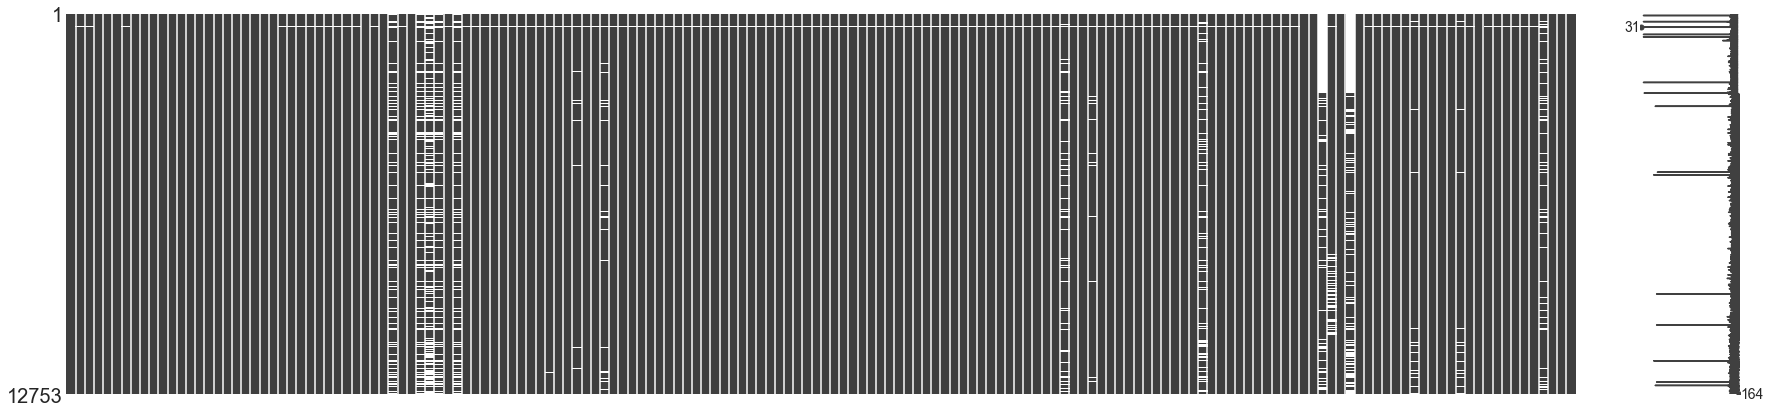

In [19]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_fbref_outfield_raw
msno.matrix(df_fbref_outfield_raw, figsize = (30, 7))

In [20]:
# Counts of missing values
null_value_stats = df_fbref_outfield_raw.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Nation       1
Pos          1
Born         1
xG          15
npxG        15
          ... 
OG          18
Recov       15
Won         15
Lost        15
Won%      1690
Length: 133, dtype: int64

The visualisation shows us very quickly that there are missing values in the dataset but as this data is scraped, this fine at this stage.

<a id='section3.3'></a>

### <a id='#section3.3'>3.3. Goalkeepers</a>

#### <a id='#section3.3.1'>3.3.1. Data Dictionary</a>
The raw dataset has one hundred and eighty eight features (columns) with the following definitions and data types:

| Variable     | Data Type    | Description    |
|------|-----|-----|
| `squad`    | object    | Squad name e.g. Arsenal    |
| `players_used`    | float64    | Number of Players used in Games    |
| `possession`    | float64    | Percentage of time with possession of the ball    |


<br>

The features will be cleaned, converted and also additional features will be created in the [Data Engineering](#section4) section (Section 4).

<a id='section3.3.2'></a>

#### <a id='#section3.3.2'>3.3.2. Import CSV files as pandas DataFrames</a>

In [21]:
# Import DataFrame as a CSV file
df_fbref_goalkeeper_raw = pd.read_csv(data_dir_fbref + f'/raw/goalkeeper/fbref_goalkeeper_stats_combined_latest.csv')

<a id='section3.3.3'></a>

#### <a id='#section3.3.3'>3.3.3. Preliminary Data Handling</a>

<a id='section3.3.3.1'></a>

##### <a id='#section3.3.3.1'>3.3.3.1. Summary Report</a>
Initial step of the data handling and Exploratory Data Analysis (EDA) is to create a quick summary report of the dataset using [pandas Profiling Report](https://github.com/pandas-profiling/pandas-profiling).

In [22]:
# Summary of the data using pandas Profiling Report
#pp.ProfileReport(df_fbref_goalkeeper_raw)

<a id='section3.3.3.2'></a>

##### <a id='#section3.3.3.2'>3.3.3.2. Further Inspection</a>
The following commands go into more bespoke summary of the dataset. Some of the commands include content covered in the [pandas Profiling](https://github.com/pandas-profiling/pandas-profiling) summary above, but using the standard [pandas](https://pandas.pydata.org/) functions and methods that most peoplem will be more familiar with.

First check the quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [23]:
# Display the first five rows of the raw DataFrame, df_fbref_goalkeeper_raw
df_fbref_goalkeeper_raw.head()

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,GA,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,PKatt,PKA,PKsv,PKm,Save%.1,Matches,FK,CK,OG,PSxG,PSxG/SoT,PSxG+/-,/90,Cmp,Att,Cmp%,Att.1,Thr,Launch%,AvgLen,Att.2,Launch%.1,AvgLen.1,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist,Gls,Ast,G-PK,PK,CrdY,CrdR,Gls.1,Ast.1,G+A,G-PK.1,G+A-PK,xG,npxG,xA,npxG+xA,xG.1,xA.1,xG+xA,npxG.1,npxG+xA.1,Mn/MP,Min%,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,On-Off.1,2CrdY,Fls,Fld,Off,Crs,Int,TklW,PKwon,PKcon,Recov,Won,Lost,Won%,League Name,League ID,Season
0,Abdoulaye Diallo,sn SEN,GK,Rennes,fr Ligue 1,25,1992,3,3,270.0,3.0,5,1.67,16,12,75.0,0,2,1,0,0.0,1,1,0,0,0.0,Matches,1,0,0,6.9,0.37,1.9,0.64,9,32,28.1,53,10,37.7,36.2,12,100.0,64.2,19,3,15.8,2,0.67,18.9,0,0,0,0,0,0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,90,7.9,NaN,3.0,0,NaN,31,0.67,4,5,-1,-0.33,-0.53,4.8,5.1,-0.3,-0.08,0.03,0,0,0,0,0,0,0,0,0,13,0,0,NaN,Big-5-European-Leagues,Big5,2017-2018
1,AdriÃ¡n,es ESP,GK,West Ham,eng Premier League,30,1987,19,19,1710.0,19.0,29,1.53,96,66,70.8,7,6,6,6,31.6,1,1,0,0,0.0,Matches,1,8,1,27.3,0.28,-0.7,-0.04,159,470,33.8,387,47,78.0,54.1,186,90.3,61.9,197,12,6.1,14,0.74,13.9,0,0,0,0,2,0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,90,50.0,NaN,19.0,0,NaN,19,1.42,30,29,1,0.05,1.16,21.4,30.3,-8.9,-0.47,0.08,0,0,3,0,0,0,0,0,0,116,0,0,NaN,Big-5-European-Leagues,Big5,2017-2018
2,Alban Lafont,fr FRA,GK,Toulouse,fr Ligue 1,18,1999,38,38,3420.0,38.0,54,1.42,161,113,70.2,9,10,19,12,31.6,6,6,0,0,0.0,Matches,3,9,0,52.6,0.30,-1.4,-0.04,239,615,38.9,793,115,55.0,44.3,206,86.9,61.5,448,41,9.2,44,1.16,17.1,0,0,0,0,4,0,0.00,0.0,0.00,0.00,0.00,0.1,0.1,0.0,0.1,0.00,0.0,0.00,0.00,0.00,90,100.0,NaN,38.0,0,NaN,0,0.97,38,54,-16,-0.42,NaN,46.0,53.3,-7.3,-0.19,NaN,0,3,7,0,0,0,0,0,1,236,0,0,NaN,Big-5-European-Leagues,Big5,2017-2018
3,Albano Bizzarri,ar ARG,GK,Udinese,it Serie A,39,1977,32,32,2880.0,32.0,52,1.62,137,91,63.5,11,4,17,8,25.0,5,2,2,1,50.0,Matches,1,9,4,42.0,0.29,-6.0,-0.19,262,612,42.8,774,135,52.5,41.1,271,76.0,53.2,306,26,8.5,13,0.41,13.0,0,0,0,0,0,1,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,90,84.2,NaN,31.0,0,NaN,5,1.16,41,52,-11,-0.34,0.32,37.1,42.6,-5.5,-0.17,0.11,0,2,3,0,0,0,0,0,0,186,0,0,NaN,Big-5-European-Leagues,Big5,2017-2018
4,Alberto Brignoli,it ITA,GK,Benevento,it Serie A,25,1991,13,11,1126.0,12.5,31,2.48,71,42,59.2,1,2,10,2,18.2,4,2,0,2,0.0,Matches,0,6,0,29.0,0.40,-2.0,-0.16,92,266,34.6,374,61,51.3,43.2,103,71.8,56.1,144,25,17.4,16,1.28,17.0,1,0,1,0,2,0,0.08,0.0,0.08,0.08,0.08,0.1,0.1,0.0,0.1,0.01,0.0,0.01,0.01,0.01,87,32.9,NaN,11.0,2,NaN,25,0.38,14,31,-17,-1.36,-0.02,13.3,25.5,-12.2,-0.97,-0.05,0,3,1,0,0,0,0,0,1,59,0,0,NaN,Big-5-European-Leagues,Big5,2017-2018


In [24]:
# Display the last five rows of the raw DataFrame, df_fbref_goalkeeper_raw
df_fbref_goalkeeper_raw.tail()

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,GA,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,PKatt,PKA,PKsv,PKm,Save%.1,Matches,FK,CK,OG,PSxG,PSxG/SoT,PSxG+/-,/90,Cmp,Att,Cmp%,Att.1,Thr,Launch%,AvgLen,Att.2,Launch%.1,AvgLen.1,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist,Gls,Ast,G-PK,PK,CrdY,CrdR,Gls.1,Ast.1,G+A,G-PK.1,G+A-PK,xG,npxG,xA,npxG+xA,xG.1,xA.1,xG+xA,npxG.1,npxG+xA.1,Mn/MP,Min%,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,On-Off.1,2CrdY,Fls,Fld,Off,Crs,Int,TklW,PKwon,PKcon,Recov,Won,Lost,Won%,League Name,League ID,Season
922,Yann Sommer,ch SUI,GK,M'Gladbach,de Bundesliga,32,1988,3,3,270.0,3.0,7,2.33,17,11,58.8,0,1,2,0,0.0,0,0,0,0,NaN,Matches,0,1,1,7.3,0.43,1.3,0.43,18,49,36.7,89,9,41.6,38.9,25,48.0,41.6,21,2,9.5,2,0.67,13.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,100.0,90.0,3.0,0,NaN,0,0.33,2,7,-5,-1.67,NaN,5.9,6.6,-0.8,-0.25,NaN,0,0,0,0,0,0,0,0,0,18,0,0,NaN,Big-5-European-Leagues,Big5,2021-2022
923,Yassine Bounou,ma MAR,GK,Sevilla,es La Liga,30,1991,2,2,180.0,2.0,1,0.50,4,3,75.0,1,1,0,1,50.0,0,0,0,0,NaN,Matches,0,0,0,0.2,0.06,-0.8,-0.38,6,14,42.9,41,10,22.0,30.1,14,35.7,38.6,14,0,0.0,4,2.00,19.9,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,66.7,90.0,2.0,0,NaN,0,2.00,2,1,1,0.50,-2.5,2.4,1.2,1.2,0.62,-2.59,0,0,0,0,0,0,0,0,0,8,0,0,NaN,Big-5-European-Leagues,Big5,2021-2022
924,Ãlex Remiro,es ESP,GK,Real Sociedad,es La Liga,26,1995,3,3,270.0,3.0,4,1.33,9,5,55.6,2,0,1,2,66.7,0,0,0,0,NaN,Matches,0,0,0,3.5,0.39,-0.5,-0.16,22,38,57.9,70,8,40.0,36.7,18,55.6,47.9,21,3,14.3,2,0.67,18.8,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,100.0,90.0,3.0,0,NaN,0,2.00,4,4,0,0.00,NaN,3.8,3.4,0.4,0.14,NaN,0,0,1,0,0,0,0,0,0,10,0,0,NaN,Big-5-European-Leagues,Big5,2021-2022
925,Åukasz FabiaÅski,pl POL,GK,West Ham,eng Premier League,36,1985,3,3,270.0,3.0,5,1.67,6,1,16.7,2,1,0,0,0.0,0,0,0,0,NaN,Matches,0,0,0,3.1,0.52,-1.9,-0.62,19,40,47.5,45,9,57.8,44.4,20,70.0,48.3,25,2,8.0,0,0.00,13.6,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,100.0,90.0,3.0,0,NaN,0,2.33,10,5,5,1.67,NaN,6.0,2.9,3.1,1.03,NaN,0,0,0,0,0,0,0,0,0,6,0,0,NaN,Big-5-European-Leagues,Big5,2021-2022
926,Åukasz Skorupski,pl POL,GK,Bologna,it Serie A,30,1991,2,2,180.0,2.0,2,1.00,6,5,83.3,1,1,0,1,50.0,1,1,0,0,0.0,Matches,0,0,0,2.1,0.29,0.1,0.03,6,28,21.4,52,7,40.4,36.8,20,35.0,34.4,16,1,6.3,0,0.00,11.4,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,100.0,90.0,2.0,0,NaN,0,2.00,3,2,1,0.50,NaN,1.8,2.6,-0.8,-0.38,NaN,0,0,0,0,0,0,0,0,0,7,0,0,NaN,Big-5-European-Leagues,Big5,2021-2022


[shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) returns a tuple representing the dimensionality of the DataFrame.

In [25]:
# Print the shape of the raw DataFrame, df_fbref_goalkeeper_raw
print(df_fbref_goalkeeper_raw.shape)

(927, 104)


The raw DataFrame has:
*    744 observations (rows), each observation represents one individual tourist stranded in Peru, and
*    20 attributes (columns).

[columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html) returns the column labels of the DataFrame.

In [26]:
# Features (column names) of the raw DataFrame, df_fbref_goalkeeper_raw
df_fbref_goalkeeper_raw.columns

Index(['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP',
       'Starts', 'Min',
       ...
       'TklW', 'PKwon', 'PKcon', 'Recov', 'Won', 'Lost', 'Won%', 'League Name',
       'League ID', 'Season'],
      dtype='object', length=104)

The [dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) method returns the data types of each attribute in the DataFrame.

In [27]:
# Data types of the features of the raw DataFrame, df_fbref_goalkeeper_raw
df_fbref_goalkeeper_raw.dtypes

Player          object
Nation          object
Pos             object
Squad           object
Comp            object
                ...   
Lost             int64
Won%           float64
League Name     object
League ID       object
Season          object
Length: 104, dtype: object

In [28]:
# Displays all one hundered and four columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_fbref_goalkeeper_raw.dtypes)

Player          object
Nation          object
Pos             object
Squad           object
Comp            object
Age              int64
Born             int64
MP               int64
Starts           int64
Min            float64
90s            float64
GA               int64
GA90           float64
SoTA             int64
Saves            int64
Save%          float64
W                int64
D                int64
L                int64
CS               int64
CS%            float64
PKatt            int64
PKA              int64
PKsv             int64
PKm              int64
Save%.1        float64
Matches         object
FK               int64
CK               int64
OG               int64
PSxG           float64
PSxG/SoT       float64
PSxG+/-        float64
/90            float64
Cmp              int64
Att              int64
Cmp%           float64
Att.1            int64
Thr              int64
Launch%        float64
AvgLen         float64
Att.2            int64
Launch%.1      float64
AvgLen.1   

The [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) method to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.

In [29]:
# Info for the raw DataFrame, df_fbref_goalkeeper_raw
df_fbref_goalkeeper_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Columns: 104 entries, Player to Season
dtypes: float64(45), int64(50), object(9)
memory usage: 753.3+ KB


The [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method to show some useful statistics for each numerical column in the DataFrame.

In [30]:
# Description of the raw DataFrame, df_fbref_goalkeeper_raw, showing some summary statistics for each numberical column in the DataFrame
df_fbref_goalkeeper_raw.describe()

,Age,Born,MP,Starts,Min,90s,GA,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,PKatt,PKA,PKsv,PKm,Save%.1,FK,CK,OG,PSxG,PSxG/SoT,PSxG+/-,/90,Cmp,Att,Cmp%,Att.1,Thr,Launch%,AvgLen,Att.2,Launch%.1,AvgLen.1,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist,Gls,Ast,G-PK,PK,CrdY,CrdR,Gls.1,Ast.1,G+A,G-PK.1,G+A-PK,xG,npxG,xA,npxG+xA,xG.1,xA.1,xG+xA,npxG.1,npxG+xA.1,Mn/MP,Min%,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,On-Off.1,2CrdY,Fls,Fld,Off,Crs,Int,TklW,PKwon,PKcon,Recov,Won,Lost,Won%
count,927.000000,927.000000,927.000000,927.000000,925.000000,927.000000,927.000000,925.000000,927.000000,927.000000,911.000000,927.000000,927.000000,927.000000,927.000000,903.000000,927.000000,927.000000,927.000000,927.000000,622.000000,927.000000,927.000000,927.000000,927.000000,911.000000,927.000000,927.000000,927.000000,927.000000,920.000000,927.000000,927.000000,925.000000,925.000000,927.000000,919.000000,919.000000,927.000000,927.000000,915.000000,927.000000,924.000000,917.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,705.000000,846.000000,927.000000,104.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,765.000000,927.000000,927.000000,927.000000,927.000000,765.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.000000,927.0,927.000000,927.000000,927.00000,927.000000,57.000000
mean,27.891046,1990.585761,16.037756,15.864078,1429.944865,15.856311,21.943905,1.494357,65.274002,45.613808,68.326894,5.930960,3.996764,5.928803,4.296656,25.054596,2.658037,2.064725,0.442287,0.151025,16.671543,0.478964,2.772384,0.642934,20.997627,0.299451,-0.269903,-0.057584,104.208198,258.993528,40.969348,387.741100,65.857605,46.045838,39.524432,116.710895,62.545702,49.192057,145.062567,11.097087,7.260546,10.186624,0.660108,14.386041,0.004315,0.026969,0.003236,0.001079,0.679612,0.055016,0.000183,0.002255,0.002438,0.000151,0.002406,0.005070,0.003452,0.039159,0.042826,0.000129,0.002244,0.002395,0.000076,0.002352,86.201726,52.877454,89.117730,15.400709,0.168285,42.701923,11.349515,1.301424,21.949299,21.957929,-0.008630,-0.114175,-0.073634,21.076591,21.104746,-0.027616,-0.081834,-0.070405,0.004315,0.387271,2.046386,0.006472,0.008630,0.036677,0.028047,0.0,0.203883,78.856526,0.02589,0.043150,36.842105
std,4.750127,4.869455,14.106800,14.204039,1271.607598,14.130571,20.109717,0.847218,59.971343,42.650898,13.616360,6.563495,4.054034,6.030815,4.646165,21.653640,2.897940,2.361525,0.765525,0.395516,23.677082,0.799122,3.051922,0.983015,19.313034,0.085490,3.389201,0.399200,104.670484,260.013457,11.591413,365.260341,63.360527,18.024168,8.203695,108.687936,24.770864,13.184107,134.363922,11.423483,5.051059,11.088721,0.564902,2.648210,0.065582,0.168611,0.056827,0.032844,1.011726,0.228135,0.003129,0.024464,0.024646,0.002972,0.024630,0.058103,0.025219,0.115010,0.119709,0.002022,0.010492,0.010713,0.001182,0.010561,12.575787,39.271308,6.025894,14.010358,0.420515,22.928712,12.663137,0.769184,22.037241,20.050890,15.247559,1.323327,1.427682,20.177644,19.201389,11.398664,1.063579,1.104272,0.065582,0.707847,2.491672,0.080234,0.092546,0.199224,0.205935,0.0,0.465281,72.322486,0.16555,0.213664,46.902132
min,17.000000,1977.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,-15.300000,-2.230000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.0

Next, we will check to see how many missing values we have i.e. the number of NULL values in the dataset, and in what features these missing values are located. This can be plotted nicely using the [missingno](https://pypi.org/project/missingno/) library (pip install missingno).

<AxesSubplot:>

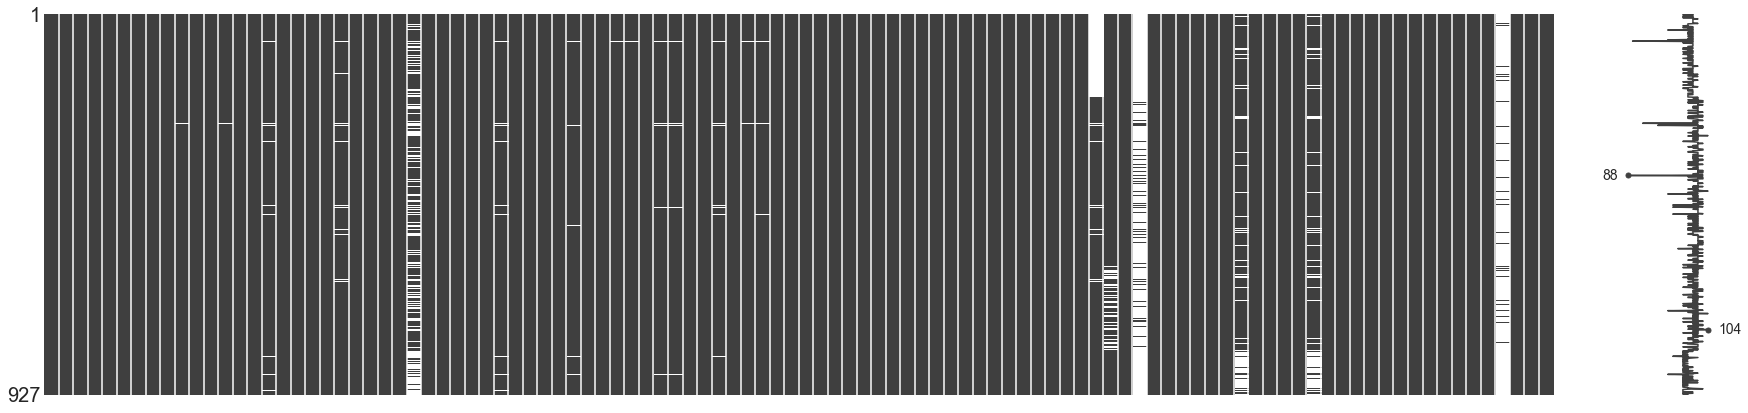

In [31]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_fbref_goalkeeper_raw
msno.matrix(df_fbref_goalkeeper_raw, figsize = (30, 7))

In [32]:
# Counts of missing values
null_value_stats = df_fbref_goalkeeper_raw.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Min            2
GA90           2
Save%         16
CS%           24
Save%.1      305
PSxG/SoT      16
Cmp%           7
Launch%        2
AvgLen         2
Launch%.1      8
AvgLen.1       8
Stp%          12
#OPA/90        3
AvgDist       10
Mn/Start     222
Compl         81
Mn/Sub       823
On-Off       162
On-Off.1     162
Won%         870
dtype: int64

The visualisation shows us very quickly that there are missing values in the dataset but as this data is scraped, this fine at this stage.

---

<a id='section4'></a>

## <a id='#section4'>4. Data Engineering</a>
Before we answer the questions in the brief through [Exploratory Data Analysis (EDA)](#section5), we'll first need to clean and wrangle the datasets to a form that meet our needs.

<a id='section4.1'></a>

### <a id='#section4.1'>4.1. Outfield Players</a>

<a id='section4.1.1'></a>

#### <a id='#section4.1.1'>4.1.1. Assign Raw DataFrame to New Engineered DataFrame</a>

In [33]:
# Assign Raw DataFrame to new Engineered DataFrame
df_fbref_outfield = df_fbref_outfield_raw

<a id='section4.1.2'></a>

#### <a id='#section4.1.2'>4.1.2. Include League Name and League Country for each team</a>

In [34]:
# Create DataFrame of Home and Away teams

## All unique Home and Away teams
lst_teams = list(df_fbref_outfield['Squad'].unique())


## DataFrames of Home and Away teams
df_teams = pd.DataFrame(lst_teams)


## Export DataFrame
if not os.path.exists(os.path.join(data_dir + '/reference/teams/fbref_teams_big5_latest.csv')):
    
    ### Save latest version
    df_teams.to_csv(data_dir + '/reference/teams/fbref_teams_big5_latest.csv', index=None, header=True)

    ### Save a copy to archive folder (dated)
    df_teams.to_csv(data_dir + f'/reference/teams/archive/fbref_teams_big5_last_updated_{today}.csv', index=None, header=True)    

else:
    df_teams = pd.read_csv(data_dir + '/reference/teams/fbref_teams_big5_latest.csv')
    print('Data already saved previously')

Data already saved previously


In [35]:
df_teams.head()

,Team Name,League Name,Team Country
0,Augsburg,Bundesliga,Germany
1,Bayern Munich,Bundesliga,Germany
2,Dortmund,Bundesliga,Germany
3,Eint Frankfurt,Bundesliga,Germany
4,Freiburg,Bundesliga,Germany


In [36]:
# Join Teams DataFrame that adds the 'league_name' and 'league_country' columns
df_fbref_outfield = pd.merge(df_fbref_outfield, df_teams, left_on='Squad', right_on='Team Name', how='left')

# Remove duplicate columns after join (contain '_y') and remove '_x' suffix from kept columns
df_fbref_outfield = df_fbref_outfield[df_fbref_outfield.columns.drop(list(df_fbref_outfield.filter(regex='_y')))]
df_fbref_outfield.columns = df_fbref_outfield.columns.str.replace('_x','')

In [37]:
df_fbref_outfield.shape

(12753, 166)

<a id='section4.1.3'></a>

#### <a id='#section4.1.3'>4.1.3. String Cleaning</a>

##### Player

In [38]:
# Remove accents and create lowercase name
df_fbref_outfield['Player Lower'] = (df_fbref_outfield['Player']
                                         .str.normalize('NFKD')
                                         .str.encode('ascii', errors='ignore')
                                         .str.decode('utf-8')
                                         .str.lower()
                                    )

In [39]:
# First Name Lower
df_fbref_outfield['First Name Lower'] = df_fbref_outfield['Player Lower'].str.rsplit(' ', 0).str[0]

# Last Name Lower
df_fbref_outfield['Last Name Lower'] = df_fbref_outfield['Player Lower'].str.rsplit(' ', 1).str[-1]

# First Initial Lower
df_fbref_outfield['First Initial Lower'] = df_fbref_outfield['Player Lower'].astype(str).str[0]

##### League Country lower

In [40]:
# Remove accents and create lowercase name
df_fbref_outfield['Team Country Lower'] = (df_fbref_outfield['Team Country']
                                               .str.normalize('NFKD')
                                               .str.encode('ascii', errors='ignore')
                                               .str.decode('utf-8')
                                               .str.lower()
                                          )

##### Countries

In [41]:
# Import reference CSV of country names and codes used to map to countries as part of the string cleaning
df_countries = pd.read_csv(data_dir + '/reference/countries/countries_all.csv')

df_countries 

,ID,Full Country Name,FIFA Code,IOC Code,ISO Code
0,1,Afghanistan,AFG,AFG,AFG
1,2,Åland Islands,ALA,NaN,ALA
2,3,Albania,ALB,ALB,ALB
3,4,Algeria,ALG,ALG,DZA
4,5,American Samoa,ASA,ASA,ASM
...,...,...,...,...,...
249,250,Wallis and Futuna,WLF,NaN,WLF
250,251,Western Sahara,ESH,NaN,ESH
251,252,Yemen,YEM,YEM,YEM
252,253,Zambia,ZAM,ZAM,ZMB


In [42]:
# Extract the nationality code
df_fbref_outfield['Nationality Code'] = df_fbref_outfield['Nation'].str.strip().str[-3:]

In [43]:
dict(zip(df_countries['FIFA Code'], df_countries['Full Country Name']))
pd.Series(df_countries['FIFA Code'].values,index=df_countries['Full Country Name']).to_dict()
dict_countries = df_countries.set_index('FIFA Code').to_dict()['Full Country Name']
dict_countries 

{'AFG': 'Afghanistan',
 'ALA': 'Åland Islands',
 'ALB': 'Albania',
 'ALG': 'Algeria',
 'ASA': 'American Samoa',
 'AND': 'Andorra',
 'ANG': 'Angola',
 'AIA': 'Anguilla',
 'ATA': 'Antarctica',
 'ATG': 'Antigua and Barbuda',
 'ARG': 'Argentina',
 'ARM': 'Armenia',
 'ARU': 'Aruba',
 'AUS': 'Australia',
 'AUT': 'Austria',
 'AZE': 'Azerbaijan',
 'BAH': 'The Bahamas',
 'BHR': 'Bahrain',
 'BAN': 'Bangladesh',
 'BRB': 'Barbados',
 'BLR': 'Belarus',
 'BEL': 'Belgium',
 'BLZ': 'Belize',
 'BEN': 'Benin',
 'BER': 'Bermuda',
 'BHU': 'Bhutan',
 'BOL': 'Bolivia',
 'BES': 'Caribbean Netherlands: Bonaire, Sint Eustatius and Saba',
 'BIH': 'Bosnia and Herzegovina',
 'BOT': 'Botswana',
 'BVT': 'Bouvet Island',
 'BRA': 'Brazil',
 'IOT': 'British Indian Ocean Territory',
 'VGB': 'British Virgin Islands',
 'BRU': 'Brunei',
 'BUL': 'Bulgaria',
 'BFA': 'Burkina Faso',
 'BDI': 'Burundi',
 'CAM': 'Cambodia',
 'CMR': 'Cameroon',
 'CAN': 'Canada',
 'CPV': 'Cape Verde',
 'CAY': 'Cayman Islands',
 'CTA': 'Central Af

In [44]:
df_fbref_outfield['Nationality Cleaned'] = df_fbref_outfield['Nationality Code'].map(dict_countries)

##### Comp

In [45]:
df_fbref_outfield['Comp'] = df_fbref_outfield['Comp'].map(dict_league_names)

##### Primary Position

In [46]:
df_fbref_outfield['Primary Pos'] = df_fbref_outfield['Pos'].str[:2]

##### Position Grouped

In [47]:
# Map grouped positions to DataFrame
df_fbref_outfield['Position Grouped'] = df_fbref_outfield['Pos'].map(dict_positions_grouped)

##### Goalkeeper / Outfielder

In [48]:
# Separate Goalkeeper and Outfielders
df_fbref_outfield['Outfielder Goalkeeper'] = np.where(df_fbref_outfield['Position Grouped'] == 'Goalkeeper', 'Goalkeeper', 'Outfielder')

<a id='section4.1.4'></a>

#### <a id='#section4.1.4'>4.1.4. Converting Data Types</a>
We are required to convert all the columns with their proper data types.

##### Age
The calculated `age` column needs to be converted from a float to an integer, with all null values ignored, using to [astype()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html) method.

In [49]:
# Redetermine the age using the newly created birth_date column (after formatted to datetime data type)

## Convert age to string
df_fbref_outfield['Age'] = df_fbref_outfield['Age'].astype(str)

## Fix 20/21 parsing that's throwing in hyphens and other numbers
df_fbref_outfield['Age'] = df_fbref_outfield['Age'].str[:2]

## Remove all not numeric values use to_numeric with parameter errors='coerce' - it replaces non numeric to NaNs
df_fbref_outfield['Age'] = pd.to_numeric(df_fbref_outfield['Age'], errors='coerce')

## Convert floats to integers and leave null values
df_fbref_outfield['Age'] = np.nan_to_num(df_fbref_outfield['Age']).astype(int)

##### Born (Birth Year)

In [50]:
# Convert string to integer
df_fbref_outfield['Born'] = pd.to_numeric(df_fbref_outfield['Born'])

<a id='section4.1.5'></a>

#### <a id='#section4.1.5'>4.1.5. Export DataFrame</a>

In [51]:
# Export DataFrame as a CSV file

## Export a copy to the FBref Engineered Outfield folder called 'latest' (can be overwritten)
df_fbref_outfield.to_csv(data_dir_fbref + '/engineered/outfield/fbref_outfield_player_stats_combined_latest.csv', index=None, header=True)

## Export a copy to the 'archive' subfolder, including the date
df_fbref_outfield.to_csv(data_dir_fbref + f'/engineered/outfield/archive/fbref_outfield_player_stats_combined_last_updated_{today}.csv', index=None, header=True)

<a id='section4.2'></a>

### <a id='#section4.2'>4.2. Goalkeepers</a>

<a id='section4.2.1'></a>

#### <a id='#section4.2.1'>4.2.1. Assign Raw DataFrame to new Engineered DataFrame</a>

In [52]:
# Assign Raw DataFrame to new Engineered DataFrame
df_fbref_goalkeeper = df_fbref_goalkeeper_raw

<a id='section4.2.2'></a>

#### <a id='#section4.2.2'>4.2.2. Include League Name and League Country for each team</a>

In [53]:
# Join Teams DataFrame that adds the 'league_name' and 'league_country' columns
df_fbref_goalkeeper = pd.merge(df_fbref_goalkeeper, df_teams, left_on='Squad', right_on='Team Name', how='left')

# Remove duplicate columns after join (contain '_y') and remove '_x' suffix from kept columns
df_fbref_goalkeeper = df_fbref_goalkeeper[df_fbref_goalkeeper.columns.drop(list(df_fbref_goalkeeper.filter(regex='_y')))]
df_fbref_goalkeeper.columns = df_fbref_goalkeeper.columns.str.replace('_x','')

In [54]:
df_fbref_goalkeeper.shape

(927, 106)

<a id='section4.2.3'></a>

#### <a id='#section4.2.3'>4.2.3. String Cleaning</a>

In [55]:
# Remove accents and create lowercase name
df_fbref_goalkeeper['Player Lower'] = (df_fbref_goalkeeper['Player']
                                           .str.normalize('NFKD')
                                           .str.encode('ascii', errors='ignore')
                                           .str.decode('utf-8')
                                           .str.lower()
                                      )

In [56]:
# First Name Lower
df_fbref_goalkeeper['First Name Lower'] = df_fbref_goalkeeper['Player Lower'].str.rsplit(' ', 0).str[0]

# Last Name Lower
df_fbref_goalkeeper['Last Name Lower'] = df_fbref_goalkeeper['Player Lower'].str.rsplit(' ', 1).str[-1]

# First Initial Lower
df_fbref_goalkeeper['First Initial Lower'] = df_fbref_goalkeeper['Player Lower'].astype(str).str[0]

##### League Country lower

In [57]:
# Remove accents and create lowercase name
df_fbref_goalkeeper['Team Country Lower'] = (df_fbref_goalkeeper['Team Country']
                                                 .str.normalize('NFKD')
                                                 .str.encode('ascii', errors='ignore')
                                                 .str.decode('utf-8')
                                                 .str.lower()
                                            )

##### Countries

In [58]:
# Extract the nationality code
df_fbref_goalkeeper['Nationality Code'] = df_fbref_goalkeeper['Nation'].str.strip().str[-3:]

In [59]:
df_fbref_goalkeeper['Nationality Cleaned'] = df_fbref_goalkeeper['Nationality Code'].map(dict_countries)

##### Comp

In [60]:
df_fbref_goalkeeper['Comp'] = df_fbref_goalkeeper['Comp'].map(dict_league_names)

##### Primary Position

In [61]:
df_fbref_goalkeeper['Primary Pos'] = df_fbref_goalkeeper['Pos'].str[:2]

##### Position Grouped

In [62]:
# Map grouped positions to DataFrame
df_fbref_goalkeeper['Position Grouped'] = df_fbref_goalkeeper['Pos'].map(dict_positions_grouped)

<a id='section4.2.4'></a>

#### <a id='#section4.2.4'>4.2.4. Converting Data Types</a>
We are required to convert all the columns with their proper data types.

##### Age
The calculated `age` column needs to be converted from a float to an integer, with all null values ignored, using to [astype()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html) method.

In [63]:
# Redetermine the age using the newly created birth_date column (after formatted to datetime data type)

## Convert age to string
df_fbref_goalkeeper['Age'] = df_fbref_goalkeeper['Age'].astype(str)

## Fix 20/21 parsing that's throwing in hyphens and other numbers
df_fbref_goalkeeper['Age'] = df_fbref_goalkeeper['Age'].str[:2]

## Remove all not numeric values use to_numeric with parameter errors='coerce' - it replaces non numeric to NaNs
df_fbref_goalkeeper['Age'] = pd.to_numeric(df_fbref_goalkeeper['Age'], errors='coerce')

## Convert floats to integers and leave null values
df_fbref_goalkeeper['Age'] = np.nan_to_num(df_fbref_goalkeeper['Age']).astype(int)

##### Born (Birth Year)

In [64]:
# Convert string to integer
df_fbref_goalkeeper['Born'] = pd.to_numeric(df_fbref_goalkeeper['Born'])

<a id='section4.2.5'></a>

#### <a id='#section4.2.5'>4.2.5. Export DataFrame</a>

In [65]:
# Export DataFrame as a CSV file

## Export a copy to the FBref Engineered Outfield folder called 'latest' (can be overwritten)
df_fbref_goalkeeper.to_csv(data_dir_fbref + '/engineered/goalkeeper/fbref_goalkeeper_stats_combined_latest.csv', index=None, header=True)

## Export a copy to the 'archive' subfolder, including the date
df_fbref_goalkeeper.to_csv(data_dir_fbref + f'/engineered/goalkeeper/archive/fbref_goalkeeper_stats_combined_last_updated_{today}.csv', index=None, header=True)

<a id='section4.3'></a>

### <a id='#section4.3'>4.3. Players and Goalkeepers Combined</a>

<a id='section4.3.1'></a>

#### <a id='#section4.3.1'>4.3.1. Concatenate DataFrames</a>
Union together both datasets.

In [66]:
df_fbref_outfield_goakeeper = pd.concat([df_fbref_outfield, df_fbref_goalkeeper])

In [67]:
df_fbref_outfield.shape

(12753, 176)

In [68]:
df_fbref_goalkeeper.shape

(927, 115)

In [69]:
df_fbref_outfield_goakeeper.shape

(13680, 205)

<a id='section4.3.2'></a>

#### <a id='#section4.3.2'>4.3.2. Dedupe Columns</a>

In [70]:
# Drop duplicate columns
df_fbref_outfield_goakeeper = df_fbref_outfield_goakeeper.loc[:,~df_fbref_outfield_goakeeper.columns.duplicated()]

In [71]:
# Remove duplicate columns after join (contain '_y') and remove '_x' suffix from kept columns
df_fbref_outfield_goakeeper = df_fbref_outfield_goakeeper[df_fbref_outfield_goakeeper.columns.drop(list(df_fbref_outfield_goakeeper.filter(regex='_y')))]
df_fbref_outfield_goakeeper.columns = df_fbref_outfield_goakeeper.columns.str.replace('_x','')

<a id='section4.3.3'></a>

#### <a id='#section4.3.3'>4.3.3. Dedupe Rows</a>

In [72]:
df_fbref_outfield_goakeeper = df_fbref_outfield_goakeeper.drop_duplicates()

In [73]:
df_fbref_outfield_goakeeper.shape

(13680, 205)

In [74]:
df_fbref_outfield_goakeeper.head()

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls.1,Ast.1,G+A,G-PK.1,G+A-PK,xG,npxG,xA,npxG+xA,xG.1,xA.1,xG+xA,npxG.1,npxG+xA.1,Matches,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,Cmp.2,Att.2,Cmp%.2,Cmp.3,Att.3,Cmp%.3,A-xA,KP,1/3,PPA,CrsPA,Prog,Live,Dead,TB,Press,Sw,Crs,CK,In,Out,Str,Ground,Low,High,Left,Right,Head,TI,Other,Off,Out.1,Int,Blocks,SCA,SCA90,PassLive,PassDead,Drib,Fld,Def,GCA,GCA90,PassLive.1,PassDead.1,Drib.1,Sh.1,Fld.1,Def.1,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl.1,Tkl%,Past,Succ,%,Def 3rd.1,Mid 3rd.1,Att 3rd.1,ShSv,Pass,Tkl+Int,Clr,Err,Touches,Def Pen,Att Pen,Succ%,#Pl,Megs,Carries,CPA,Mis,Dis,Targ,Rec,Rec%,Prog.1,Mn/MP,Min%,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,On-Off.1,2CrdY,Fls,PKwon,PKcon,OG,Recov,Won,Lost,Won%,League Name,League ID,Season,Team Name,Team Country,Player Lower,First Name Lower,Last Name Lower,First Initial Lower,Team Country Lower,Nationality Code,Nationality Cleaned,Primary Pos,Position Grouped,Outfielder Goalkeeper,GA,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,PKA,PKsv,PKm,Save%.1,PSxG,PSxG/SoT,PSxG+/-,/90,Thr,Launch%,AvgLen,Launch%.1,AvgLen.1,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist
0,Aaron Cresswell,eng ENG,DF,West Ham,Premier League,27,1989.0,36,35,3069.0,34.1,1,3,1,0,0,7,0,0.03,0.09,0.12,0.03,0.12,0.8,0.8,2.8,3.6,0.02,0.08,0.10,0.02,0.10,Matches,21.0,6.0,28.6,0.62,0.18,0.05,0.17,28.1,8.0,0.04,0.2,0.2,1224.0,1708.0,71.7,23519.0,10212.0,560.0,623.0,89.9,472.0,587.0,80.4,183.0,449.0,40.8,0.2,35.0,117.0,21.0,14.0,96.0,1343.0,365.0,1.0,222.0,83.0,93.0,67.0,35.0,15.0,9.0,893.0,293.0,522.0,1329.0,78.0,59.0,210.0,5.0,15.0,44.0,39.0,52.0,62.0,1.82,35.0,21.0,1.0,3.0,0.0,9.0,0.26,6.0,3.0,0.0,0.0,0.0,0.0,38.0,18.0,15.0,18.0,5.0,17.0,53.1,15.0,115.0,32.1,181.0,123.0,54.0,0.0,38.0,90.0,133.0,0.0,2050.0,125.0,17.0,33.3,7.0,0.0,1071.0,2.0,18.0,19.0,1171.0,1094.0,93.4,31.0,85,89.7,NaN,30.0,1,NaN,1,1.14,45.0,60.0,-15.0,-0.44,0.84,38.0,51.5,-13.5,-0.40,1.09,0.0,20,0.0,0.0,0.0,277.0,70.0,57.0,55.1,Big-5-European-Leagues,Big5,2017-2018,West Ham,England,aaron cresswell,aaron,cresswell,a,england,ENG,England,DF,Defender,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Hunt,de GER,"MF,FW",Hamburger SV,Bundeliga,30,1986.0,28,26,2081.0,23.1,3,2,2,1,1,1,0,0.13,0.09,0.22,0.09,0.17,2.8,2.1,5.6,7.6,0.12,0.23,0.35,0.09,0.32,Matches,27.0,6.0,22.2,1.17,0.26,0.07,0.33,23.4,10.0,0.08,0.2,-0.1,883.0,1229.0,71.8,16889.0,5315.0,406.0,480.0,84.6,292.0,376.0,77.7,165.0,303.0,54.5,-3.6,65.0,83.0,31.0,5.0,97.0,977.0,252.0,11.0,245.0,67.0,66.0,123.0,35.0,41.0,14.0,672.0,236.0,321.0,999.0,137.0,42.0,23.0,9.0,5.0,29.0,29.0,49.0,102.0,4.25,54.0,43.0,1.0,2.0,1.0,6.0,0.25,5.0,1.0,0.0,0.0,0.0,0.0,30.0,22.0,12.0,16.0,2.0,5.0,13.5,32.0,135.0,27.9,102.0,261.0,121.0,0.0,28.0,44.0,21.0,0.0,1475.0,28.0,68.0,58.3,23.0,4.0,892.0,7.0,45.0,42.0,1176.0,893.0,75.9,178.0,74,68.0,NaN,14.0,2,NaN,0,1.07,22.0,34.0,-12.0,-0.52,0.58,27.0,31.3,-4.3,-0.18,0.94,0.0,27,0.0,0.0,0.0,213.0,22.0,37.0,37.3,Big-5-European-Leagues,Big5,2017-2018,Hamburger SV,Germany,aaron hunt,aaron,hunt,a,germany,GER,Germany,MF,Midfielder,Outfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Lennon,eng ENG,MF,Burnley,Premier League,30,1987.0,14,13,1118.0,12.4,0,2,0,0,0,2,0,0.00,0.16,0.16,0.00,0.16,0.6,0.6,1.4,2.0,0.05,0.11,0.16,0.05,0.16,Matches,10.0,4.0,40.0,0.81,0.32,0.00,0.00,16.6,0.0,0.06,-0.6,-0.6,204.0,294.0,69.4,3223.0,887.0,116.0,142.0,81.7,68.0,92.0,73.9,17.0,34.0,50.0,0.6,8.0,11.0,13.0,5.0,22.0,289.0,5.0,0.0,61.0,5.0,19.0,0.0,0.0,0.0,0.0,193.0,51.0,50.0,27.0,250.0,7.0,4.0,3.0,0.0,9.0,8.0,30.0,18.0,1.45,12.0,0.0,1.0,1.0,0.0,3.0,0.24,2.0,0.0,0.0,1.0,0.0,0.0,18.0,10.0,6.0,11.0,1.0,4.0,19.0,17.0,61.0,26.3,74.0,102.0,56.0,0.0,24.0,31.0,9.0,0.0,424.0,19.0,36.0,48.0,12.0,

<a id='section4.3.4'></a>

#### <a id='#section4.3.4'>4.3.4. Reorder Columns</a>

In [75]:
# Do this later

<a id='section4.3.5'></a>

#### <a id='#section4.3.5'>4.3.5. Export DataFrame</a>

In [76]:
# Export DataFrame as a CSV file

## Export a copy to the FBref Engineered Outfield-Goalkeeper folder called 'latest' (can be overwritten)
df_fbref_outfield_goakeeper.to_csv(data_dir_fbref + '/engineered/outfield-goalkeeper-combined/fbref_outfield_player_goalkeeper_stats_combined_latest.csv', index=None, header=True)

## Export a copy to the 'archive' subfolder, including the date
df_fbref_outfield_goakeeper.to_csv(data_dir_fbref + f'/engineered/outfield-goalkeeper-combined/archive/fbref_outfield_player_goalkeeper_stats_combined_last_updated_{today}.csv', index=None, header=True)

## Export a copy to the Export folder (can be overwritten)
df_fbref_outfield_goakeeper.to_csv(data_dir + '/export/fbref_players_big5_latest.csv', index=None, header=True)

---

<a id='section5'></a>

## <a id='#section5'>5. Summary</a>
This notebook scrapes player performance data from [StatsBomb](https://statsbomb.com/) via [FBref](https://fbref.com/en/), using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames, [Beautifulsoup](https://pypi.org/project/beautifulsoup4/) for webscraping.

With this notebook we now have aggregated player performance data for players in the 'Big 5' European leagues for the 17/18-present seasons.

---

<a id='section6'></a>

## <a id='#section6'>6. Next Steps</a>
This data is now ready to be exported and analysed in further Jupyter notebooks or Tableau.

The Data Engineering subfolder in GitHub can be found [here](https://github.com/eddwebster/football_analytics/tree/master/notebooks/B\)%20Data%20Engineering) and a static version of the record linkage notebook in which the FBref data is joined to TransferMarkt data can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/B%29%20Data%20Engineering/Record%20Linkage%20of%20FBref%20and%20TransferMarkt%20Datasets.ipynb).

---

<a id='section7'></a>

## <a id='#section7'>7. References</a>

#### Data and Web Scraping
*    [FBref](https://fbref.com/) for the data to scrape
*    FBref statement for using StatsBomb's data: https://fbref.com/en/statsbomb/
*    [StatsBomb](https://statsbomb.com/) providing the data to FBref
*    [FBref_EPL GitHub repository](https://github.com/chmartin/FBref_EPL) by [chmartin](https://github.com/chmartin) for the original web scraping code
*    [Scrape-FBref-data GitHub repository](https://github.com/parth1902/Scrape-FBref-data) by [parth1902](https://github.com/parth1902) for the revised web scraping code for the new FBref metrics


#### Countries
*    [Comparison of alphabetic country codes Wiki](https://en.wikipedia.org/wiki/Comparison_of_alphabetic_country_codes)

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)